In [1]:
!pip install -q nibabel imageio scikit-image tensorflow kagglehub

import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from skimage.measure import label
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import kagglehub
from google.colab import files

In [2]:
n_patients = 60
modalities = ["Flair", "T1", "T2"]

# Dataset da Kaggle
path = kagglehub.dataset_download("orvile/multiple-sclerosis-brain-mri-lesion-segmentation")

base_path = path  # Path .nii
output_path = '/content/slices'  # Path slice 2D in png
os.makedirs(output_path, exist_ok=True)


Using Colab cache for faster access to the 'multiple-sclerosis-brain-mri-lesion-segmentation' dataset.


In [3]:
def load_all_volumes(base_path, n_patients, modality, target_shape=(128,128,64)):
    volumes = []
    masks = []
    patient_ids = []
    for i in range(1, n_patients+1):
        try:
          img_path = os.path.join(base_path, f'Patient-{i}', f'{i}-{modality}.nii')
          mask_path = os.path.join(base_path, f'Patient-{i}', f'{i}-LesionSeg-{modality}.nii')

          if not os.path.exists(img_path) or not os.path.exists(mask_path):
              continue

          img_data = nib.load(img_path).get_fdata()
          mask_data = nib.load(mask_path).get_fdata()

          img_data = ((img_data - np.min(img_data)) * 255 / (np.max(img_data) - np.min(img_data))).astype(np.uint8)
          mask_data = ((mask_data > 0) * 255).astype(np.uint8)

          # Ridimensionamento
          img_resized = resize(img_data, target_shape, order=3, preserve_range=True,anti_aliasing=True).astype(np.uint8)
          mask_resized = resize(mask_data, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

          volumes.append(img_resized)
          masks.append(mask_resized)
          patient_ids.append(i)

        except Exception as e:
          print(f"Patient-{i}: Error - {e}")
          continue
    return volumes, masks, patient_ids


In [4]:
def get_train_val_test_split(volumes, masks, patient_ids, test_size=0.2, val_size=0.2, random_state=42):
  indices = np.arange(len(volumes))

  train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
  train_idx, val_idx = train_test_split(train_idx, test_size=val_size/(1-test_size), random_state=random_state)

  split_data = {
    'train': ([volumes[i] for i in train_idx], [masks[i] for i in train_idx], [patient_ids[i] for i in train_idx]),
    'val': ([volumes[i] for i in val_idx], [masks[i] for i in val_idx], [patient_ids[i] for i in val_idx]),
    'test': ([volumes[i] for i in test_idx], [masks[i] for i in test_idx], [patient_ids[i] for i in test_idx])
  }

  return split_data


def augment_volume_3d(volume, mask):
    # Variazione intensità
    if np.random.rand() > 0.5:
        brightness = np.random.uniform(0.9, 1.1)
        volume = np.clip(volume * brightness, 0, 1)

    # Gaussian noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, volume.shape)
        volume = np.clip(volume + noise, 0, 1)

    return volume, mask


def create_3d_dataset(volumes, masks, batch_size=2, is_training=True):
    aug_volumes, aug_masks = [], []

    for vol, mask in zip(volumes, masks):
        vol = vol.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        if is_training:
            vol, mask = augment_volume_3d(vol.copy(), mask.copy())
        aug_volumes.append(vol[..., np.newaxis])
        aug_masks.append(mask[..., np.newaxis])

    volumes_array = np.array(aug_volumes, dtype=np.float32)
    masks_array = np.array(aug_masks, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((volumes_array, masks_array))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def unet_3d_model(input_shape=(128, 128, 64, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)

    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)

    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)

    c4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling3D((2, 2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.5)(c5)
    c5 = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [5]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    return 1 - tf.reduce_mean((2. * intersection + smooth) /
                              (tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1) + smooth))


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-7):
    y_pred = tf.clip_by_value(y_pred, smooth, 1 - smooth)
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_term = tf.pow(1 - p_t, gamma)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

    focal = alpha_t * focal_term * bce
    return tf.reduce_mean(focal)


def combined_loss(y_true, y_pred):
    return 0.35 * dice_loss(y_true, y_pred) + 0.65 * focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0)



In [6]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [7]:
def train_3d_model(modality, target_shape=(128, 128, 64)):
    print(f"Training 3D - {modality}")

    volumes, masks, patient_ids = load_all_volumes(base_path, n_patients, modality, target_shape)

    data_split = get_train_val_test_split(volumes, masks, patient_ids)

    batch_size = 2  # Ridotto per memoria GPU
    train_dataset = create_3d_dataset(data_split['train'][0], data_split['train'][1], batch_size=batch_size, is_training=True)
    val_dataset = create_3d_dataset(data_split['val'][0], data_split['val'][1], batch_size=batch_size, is_training=False)

    model = unet_3d_model(input_shape=(*target_shape, 1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[dice_coef, iou_coef,
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    early_stop = EarlyStopping(monitor='val_dice_coef', patience=15, mode='max', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=7, min_lr=1e-7, mode='max', verbose=1)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stop, reduce_lr]
    )

    # Test
    test_dataset = create_3d_dataset(data_split['test'][0], data_split['test'][1], batch_size=batch_size, is_training=False)
    results = model.evaluate(test_dataset)

    print(f"Risultati - {modality}")
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Dice: {results[1]:.4f}")
    print(f"Test IoU: {results[2]:.4f}")
    print(f"Test Precision: {results[3]:.4f}")
    print(f"Test Recall: {results[4]:.4f}")
    print(f"Test Accuracy: {results[5]:.4f}")

    model.save(f'/content/model_3d_{modality.lower()}.h5')

    return model, history, data_split

In [8]:
def visualize_3d_prediction(model, volume, mask, history, modality, slice_idx=None):
    if slice_idx is None:
        slice_idx = volume.shape[2] // 2

    # Predizione
    pred = model.predict(volume[np.newaxis, ..., np.newaxis], verbose=0)[0, :, :, :, 0]
    pred_binary = (pred > 0.5).astype(float)

    # Visualizzazione
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(volume[:, :, slice_idx], cmap='gray')
    axes[0].set_title('Volume')
    axes[0].axis('off')

    axes[1].imshow(mask[:, :, slice_idx], cmap='gray')
    axes[1].set_title('Maschera Reale')
    axes[1].axis('off')

    axes[2].imshow(pred_binary[:, :, slice_idx], cmap='gray')
    axes[2].set_title('Predizione 3D')
    axes[2].axis('off')

    plt.tight_layout()

    save_file = f"/content/predict_{modality}.png"
    os.makedirs(os.path.dirname(save_file), exist_ok=True)

    plt.savefig(save_file)
    files.download(save_file)
    plt.show()

    if history:
        plt.figure(figsize=(10,5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        if 'dice_coef' in history.history:
            plt.plot(history.history['dice_coef'], label='Train Dice')
            plt.plot(history.history['val_dice_coef'], label='Val Dice')
        plt.title("Andamento Addestramento")
        plt.xlabel("Epoch")
        plt.ylabel("Valori")
        plt.legend()

        history_file = f"/content/training_history_{modality}.png"
        os.makedirs(os.path.dirname(history_file), exist_ok=True)

        plt.savefig(history_file)
        files.download(history_file)
        plt.show()




Training 3D - Flair
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 519ms/step - accuracy: 0.9415 - dice_coef: 0.0054 - iou_coef: 0.0027 - loss: 0.3750 - precision: 3.1592e-06 - recall: 1.0978e-04 - val_accuracy: 0.9964 - val_dice_coef: 0.0051 - val_iou_coef: 0.0026 - val_loss: 0.3679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.9972 - dice_coef: 0.0026 - iou_coef: 0.0013 - loss: 0.3634 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9964 - val_dice_coef: 4.3612e-04 - val_iou_coef: 2.1813e-04 - val_loss: 0.3611 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.9972 - dice_coef: 0.0016 - iou_coef: 7.8798e-04 - loss: 0.3567 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9964 - val_dice_coef: 0.0074 - val_iou_coef: 0.0037 - val_loss: 0.3512 - val_precision: 0.0000e+00 

Risultati - Flair
Test Loss: 0.2265
Test Dice: 0.4081
Test IoU: 0.2628
Test Precision: 0.6124
Test Recall: 0.3876
Test Accuracy: 0.9972


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

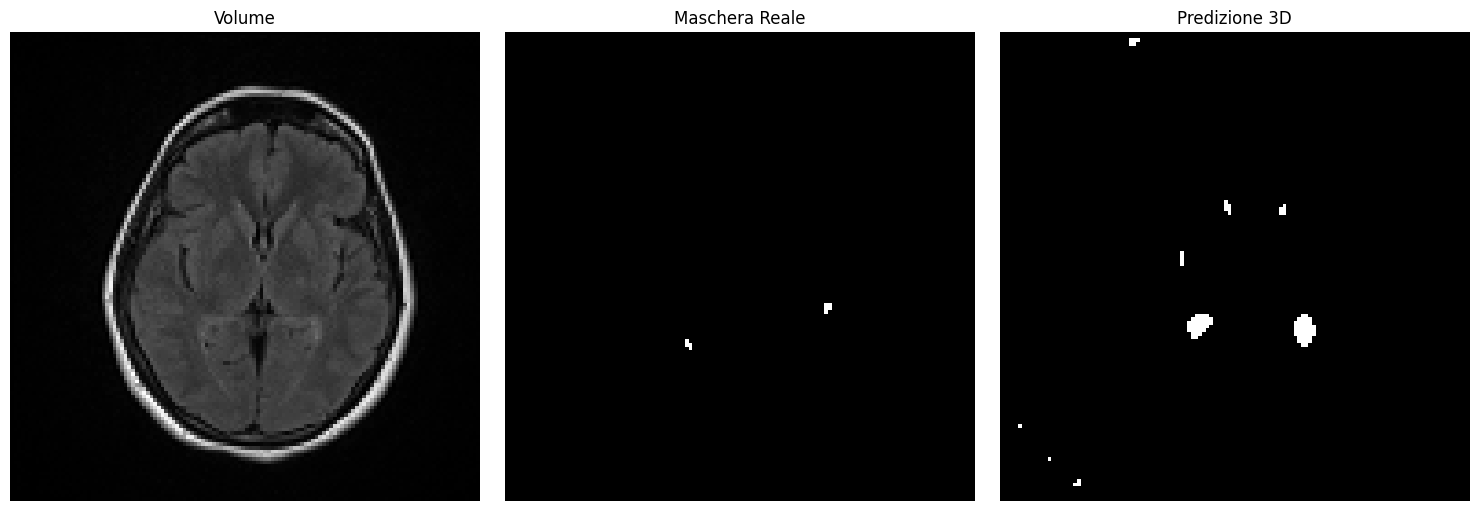

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

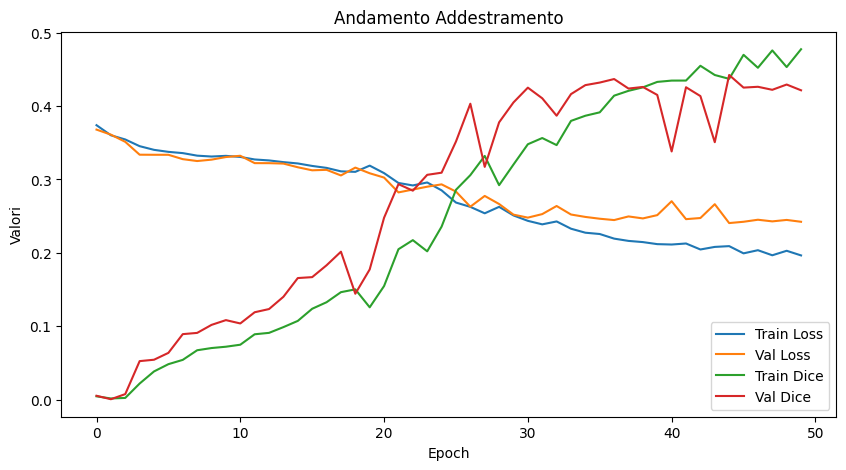

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

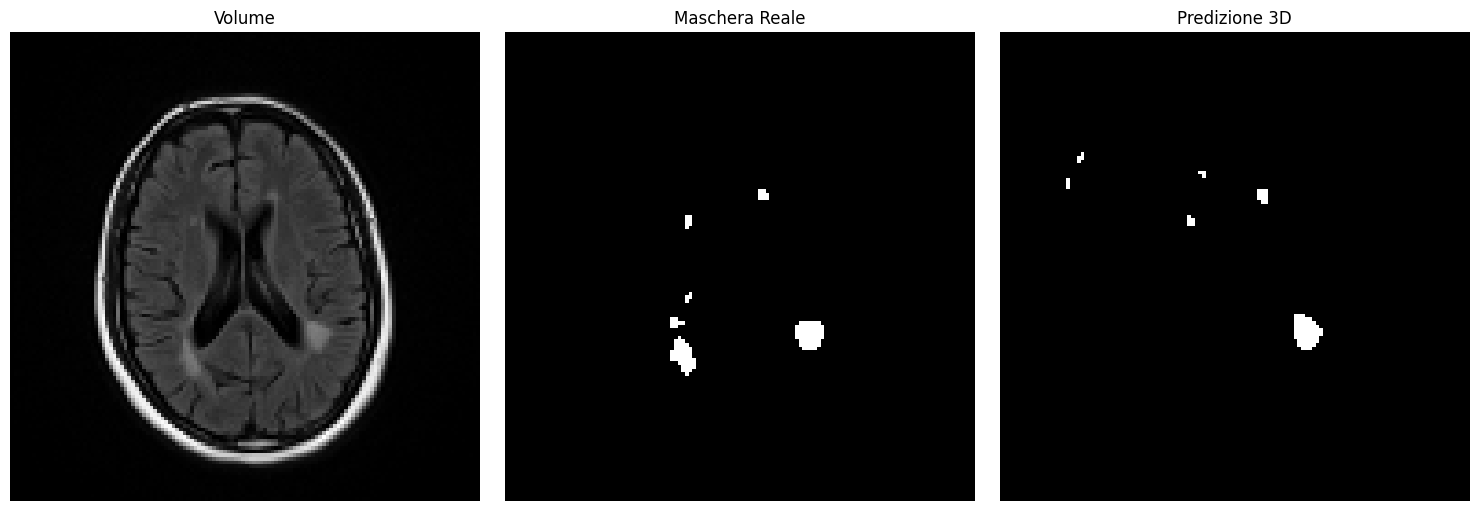

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

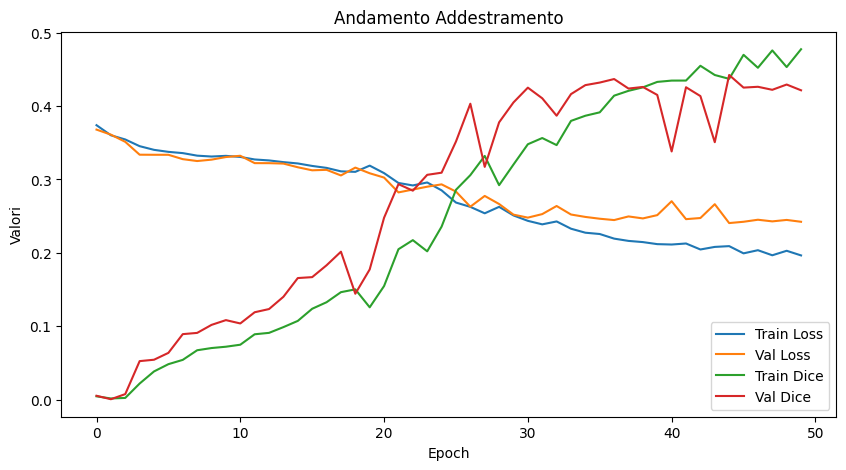

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

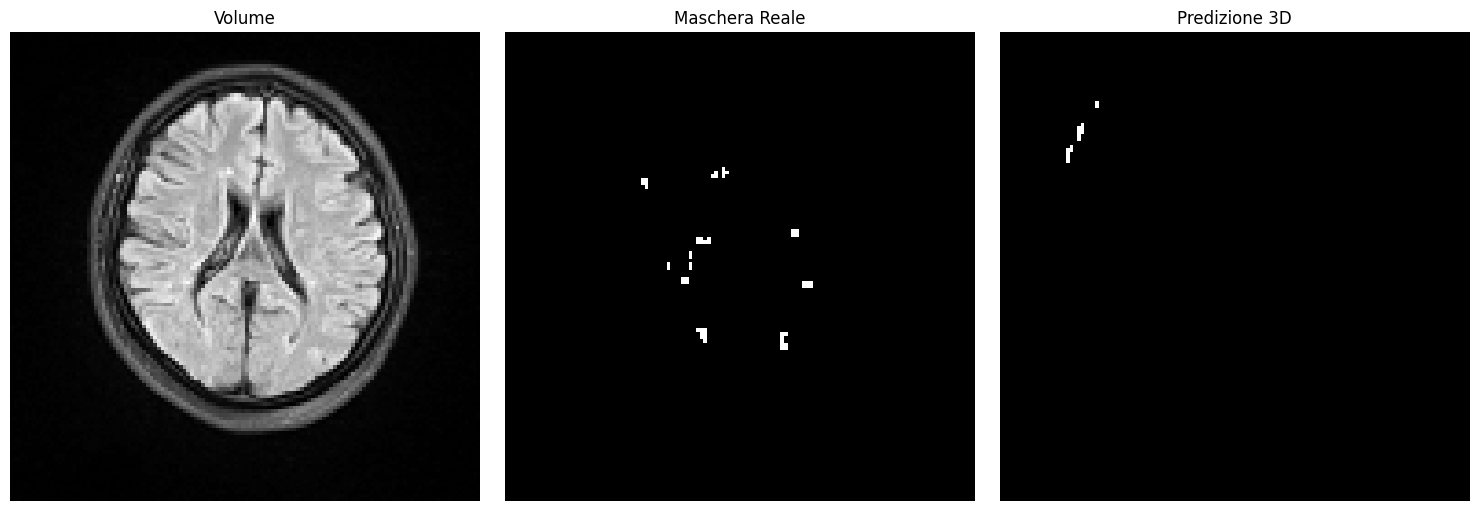

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

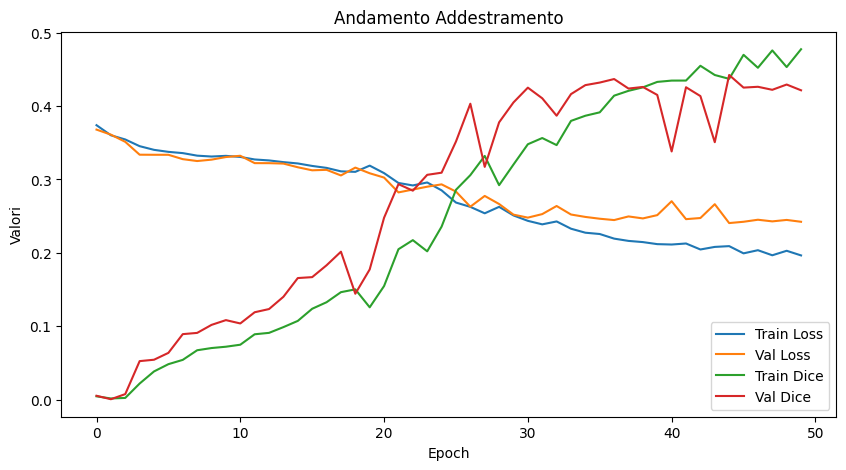

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

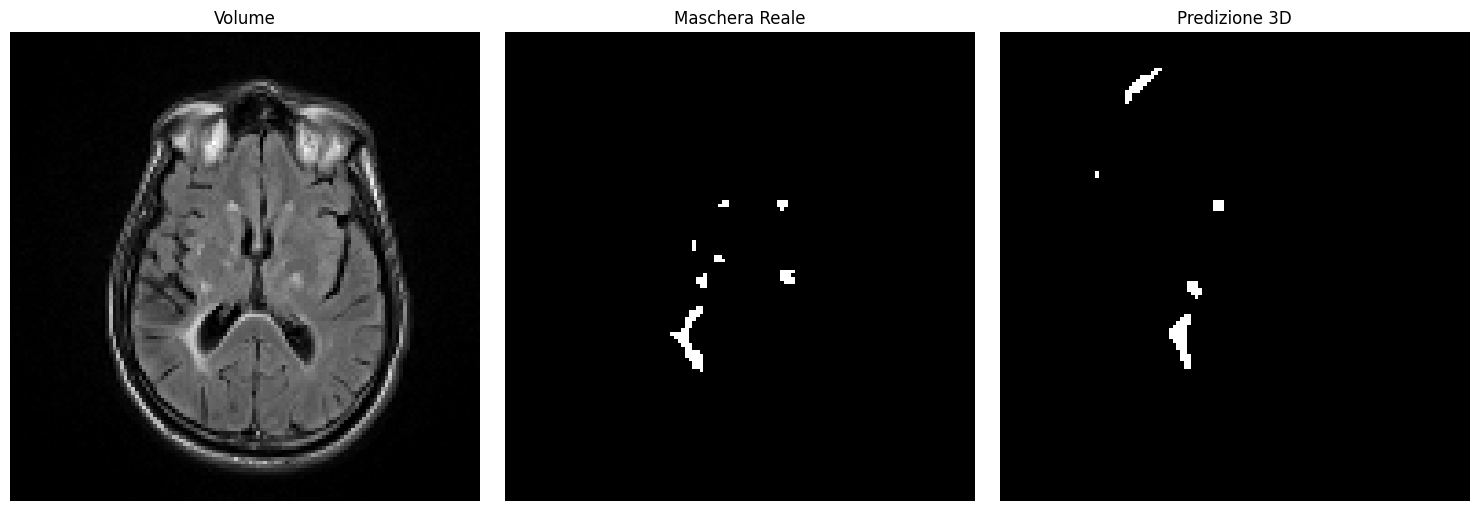

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

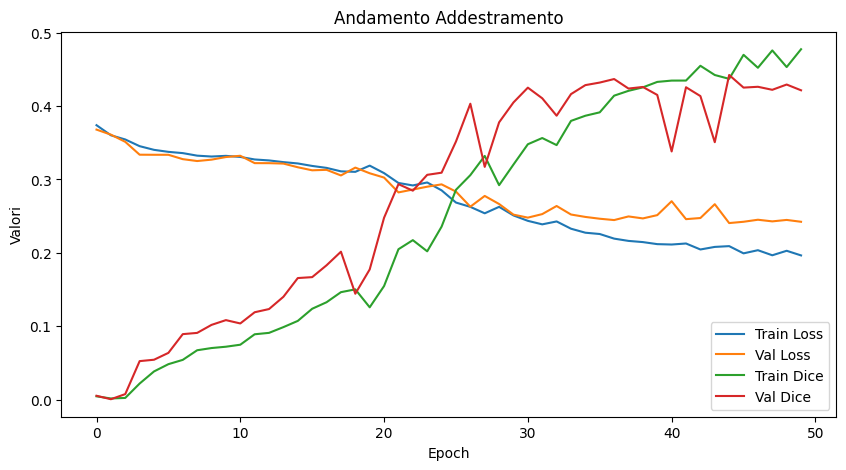

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

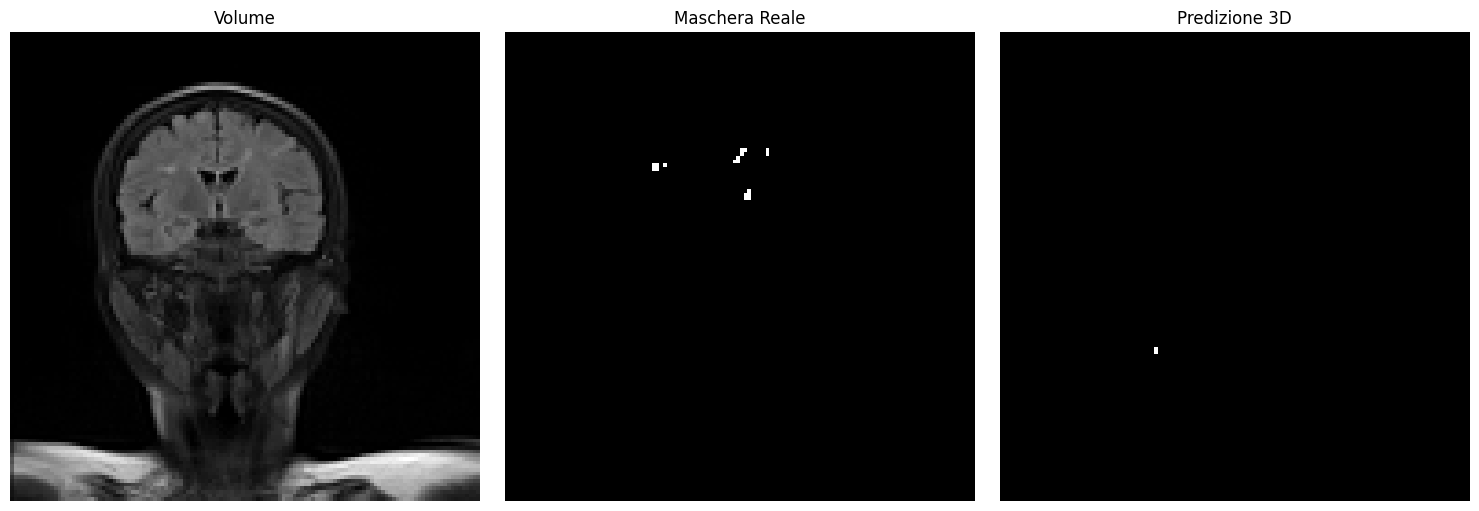

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

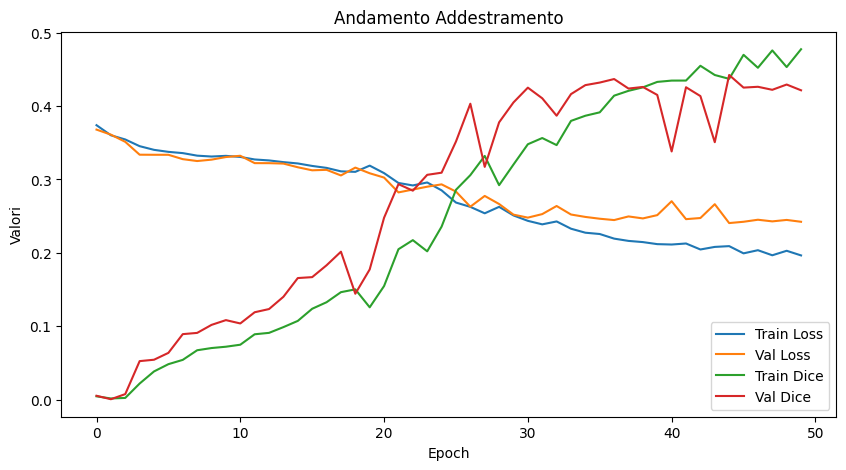

In [10]:
modality = "Flair"

model_3d, history, data_split = train_3d_model(modality, target_shape=(128, 128, 64))

# Visualizzazione
test_volumes, test_masks, test_ids = data_split['test']
# Prova diversi pazienti finché non trovi una buona segmentazione
for i in [0, 1, 2, 3, 4]:
    visualize_3d_prediction(model_3d, test_volumes[i], test_masks[i], history, modality)

Training 3D - T1
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 515ms/step - accuracy: 0.7629 - dice_coef: 0.0016 - iou_coef: 8.1453e-04 - loss: 0.3767 - precision: 6.2686e-04 - recall: 0.2119 - val_accuracy: 0.9995 - val_dice_coef: 8.5346e-04 - val_iou_coef: 4.2700e-04 - val_loss: 0.3704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.9992 - dice_coef: 0.0011 - iou_coef: 5.5278e-04 - loss: 0.3640 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9995 - val_dice_coef: 1.2058e-10 - val_iou_coef: 1.2058e-10 - val_loss: 0.3539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.9992 - dice_coef: 2.3111e-06 - iou_coef: 1.1561e-06 - loss: 0.3565 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9995 - val_dice_coef: 1.3499e-09 - val_iou_coef: 1.3499e-09 - val_loss: 0.3539 - val_p

Risultati - T1
Test Loss: 0.3706
Test Dice: 0.0007
Test IoU: 0.0003
Test Precision: 0.0000
Test Recall: 0.0000
Test Accuracy: 0.9996


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

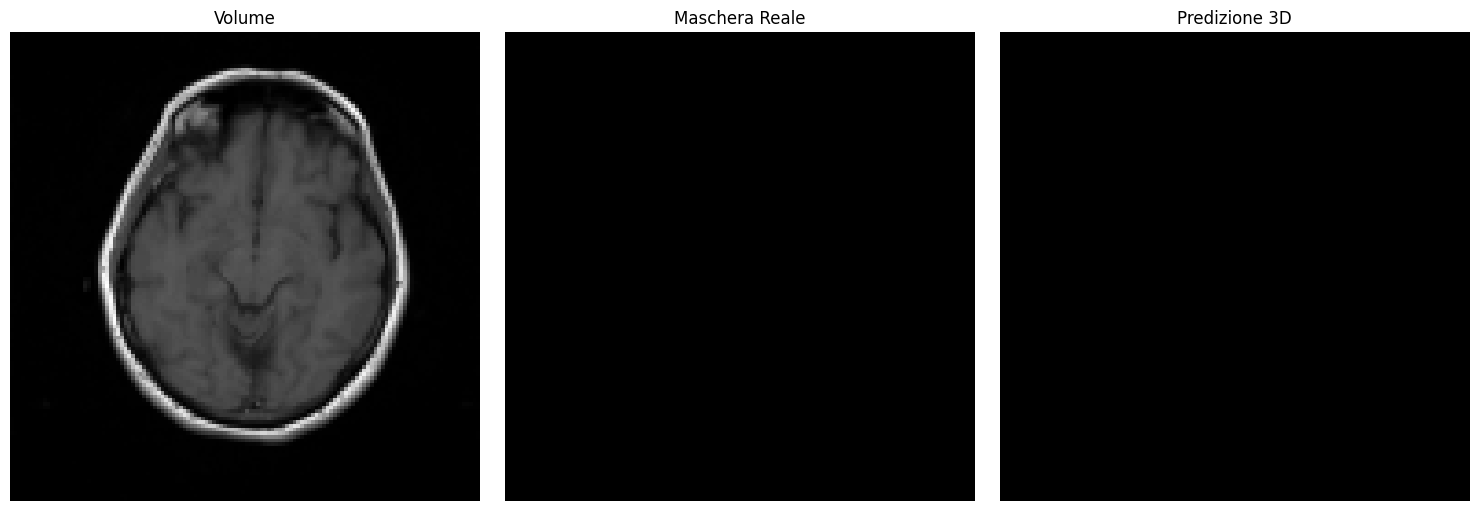

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

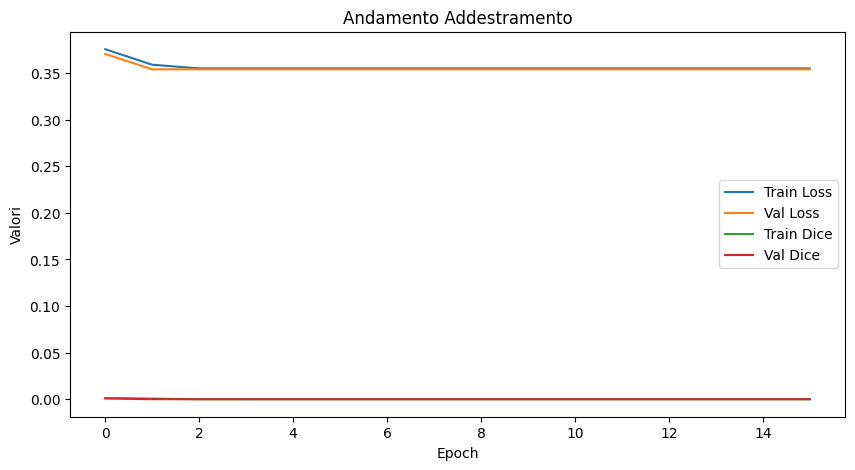

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

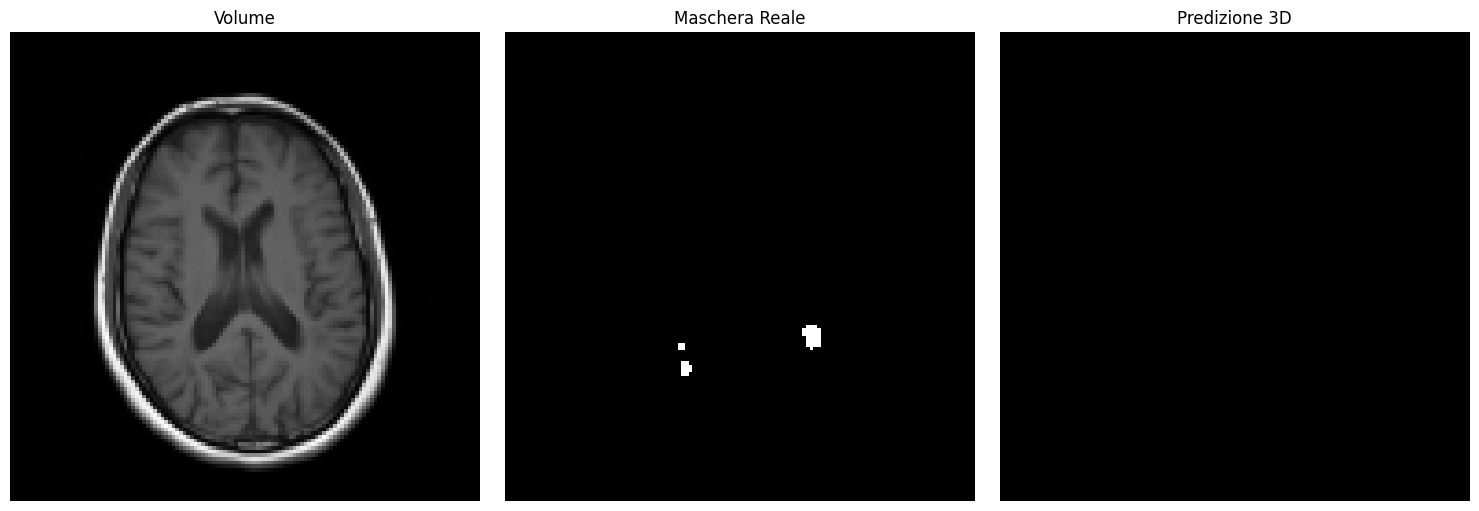

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

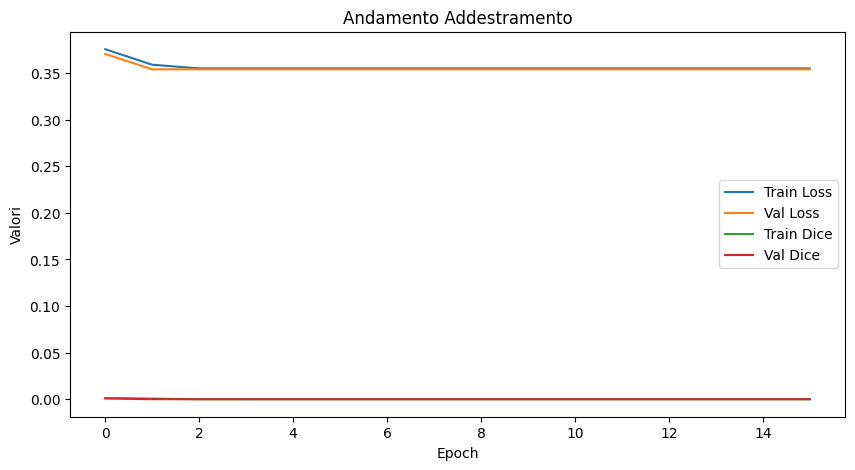

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

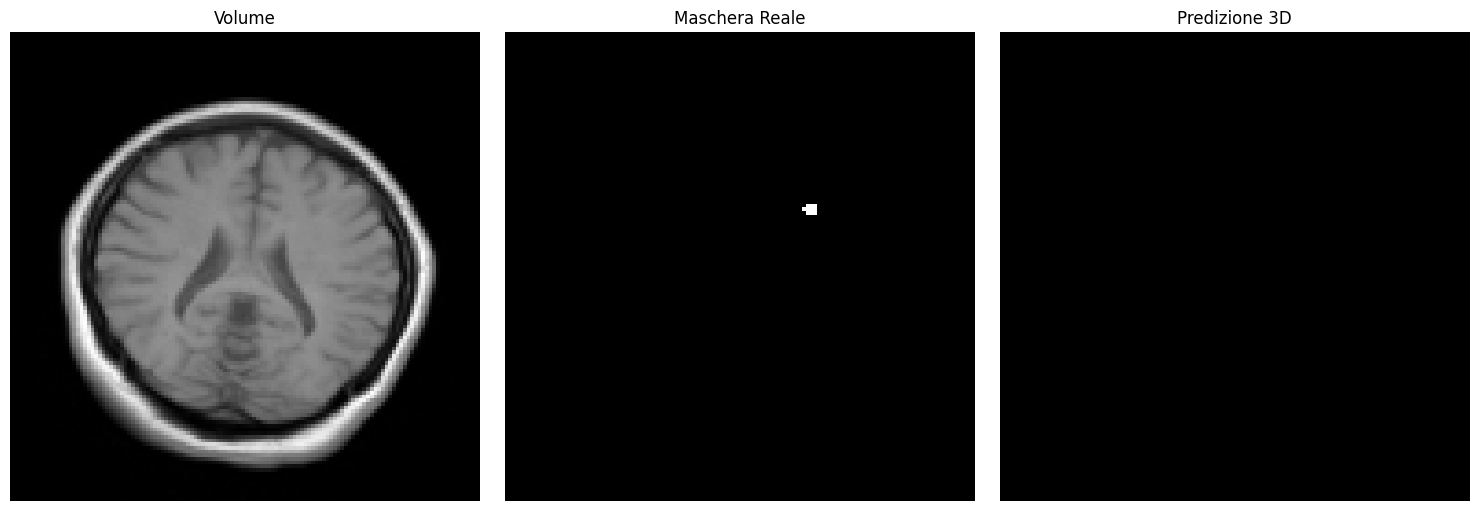

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

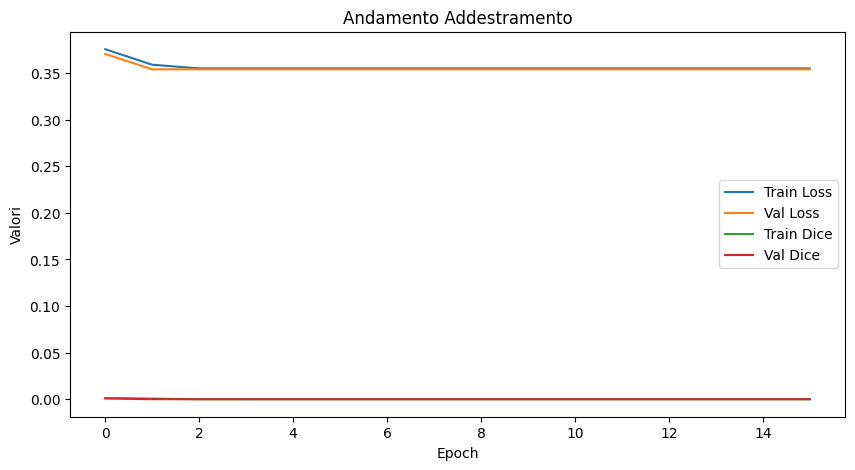

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

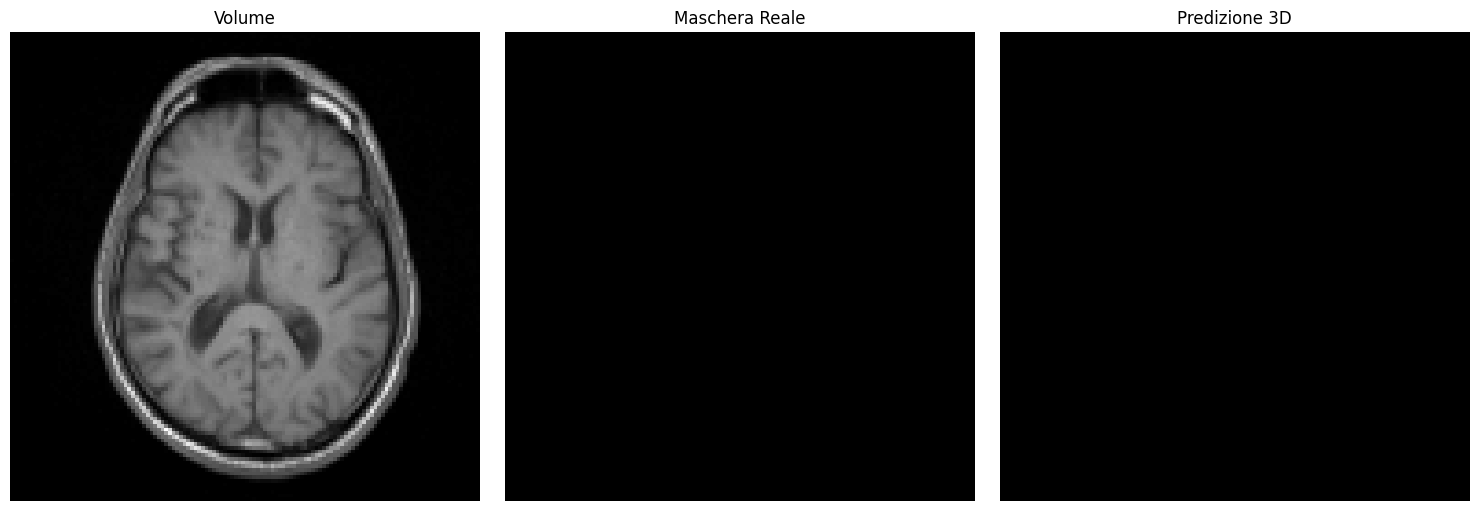

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

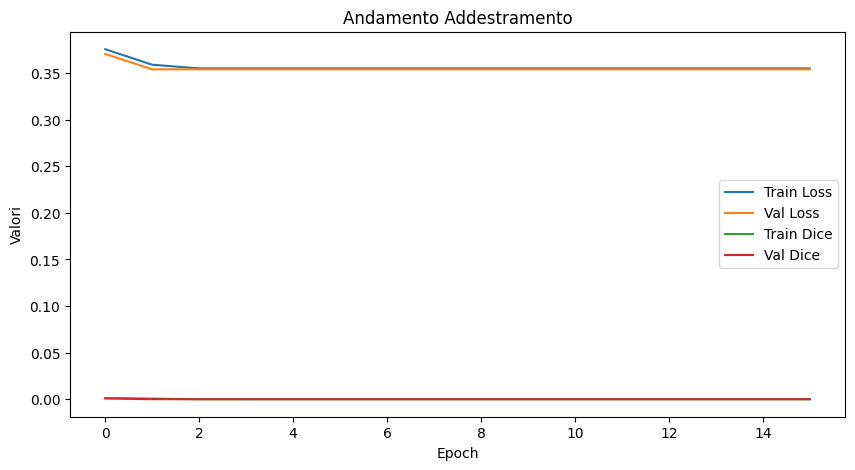

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

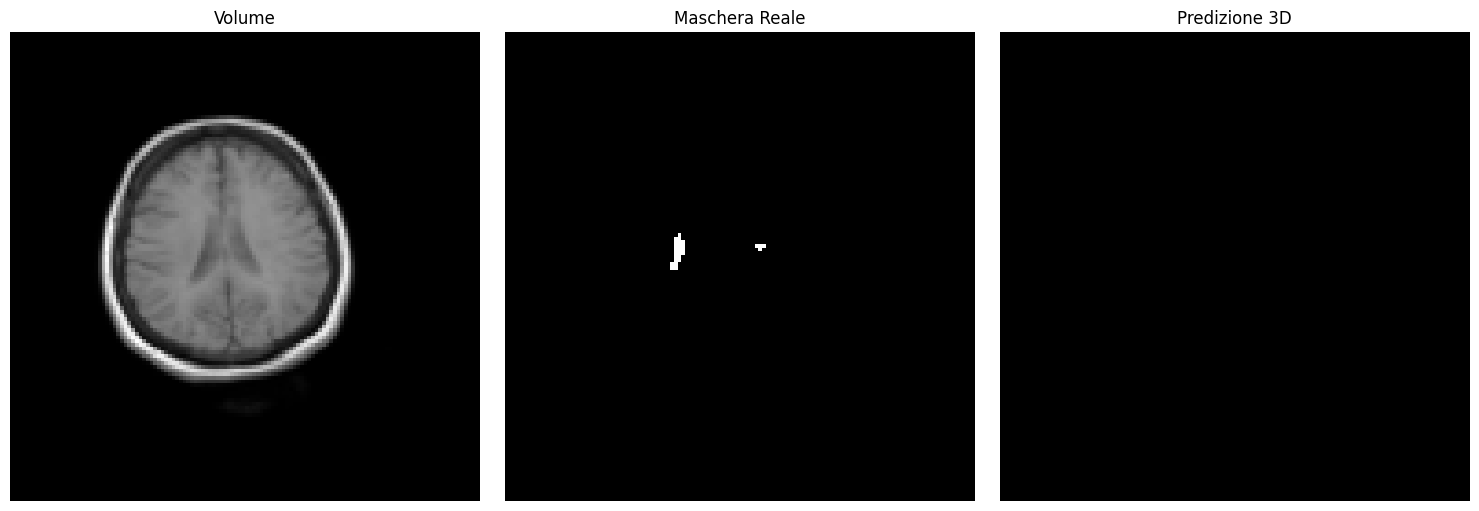

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

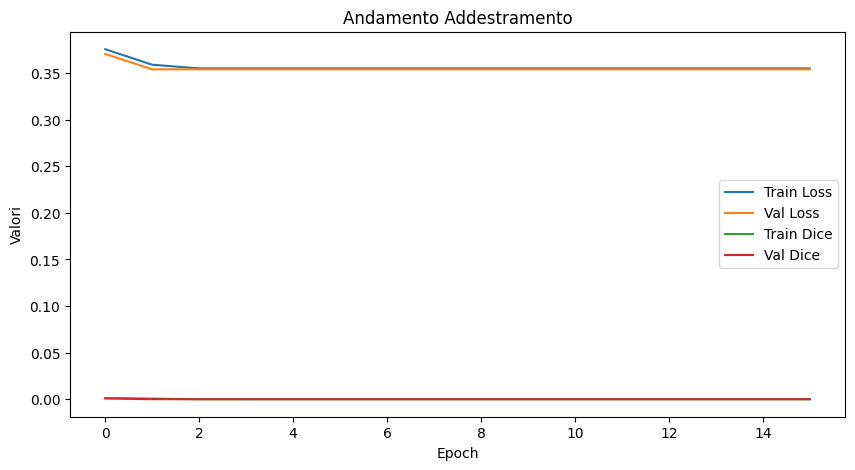

In [11]:
modality = "T1"

model_3d, history, data_split = train_3d_model(modality, target_shape=(128, 128, 64))

# Visualizzazione
test_volumes, test_masks, test_ids = data_split['test']
# Prova diversi pazienti finché non trovi una buona segmentazione
for i in [0, 1, 2, 3, 4]:
    visualize_3d_prediction(model_3d, test_volumes[i], test_masks[i], history, modality)

Training 3D - T2
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 513ms/step - accuracy: 0.9916 - dice_coef: 0.0038 - iou_coef: 0.0019 - loss: 0.3741 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9979 - val_dice_coef: 8.3795e-04 - val_iou_coef: 4.1924e-04 - val_loss: 0.3638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9980 - dice_coef: 2.0798e-04 - iou_coef: 1.0401e-04 - loss: 0.3619 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9979 - val_dice_coef: 4.5545e-05 - val_iou_coef: 2.2773e-05 - val_loss: 0.3587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.9980 - dice_coef: 6.1702e-04 - iou_coef: 3.0883e-04 - loss: 0.3566 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9979 - val_dice_coef: 0.0029 - val_iou_coef: 0.0014 - val_loss: 0.3521 - val_preci

Risultati - T2
Test Loss: 0.3060
Test Dice: 0.1689
Test IoU: 0.0962
Test Precision: 0.2473
Test Recall: 0.2497
Test Accuracy: 0.9968


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

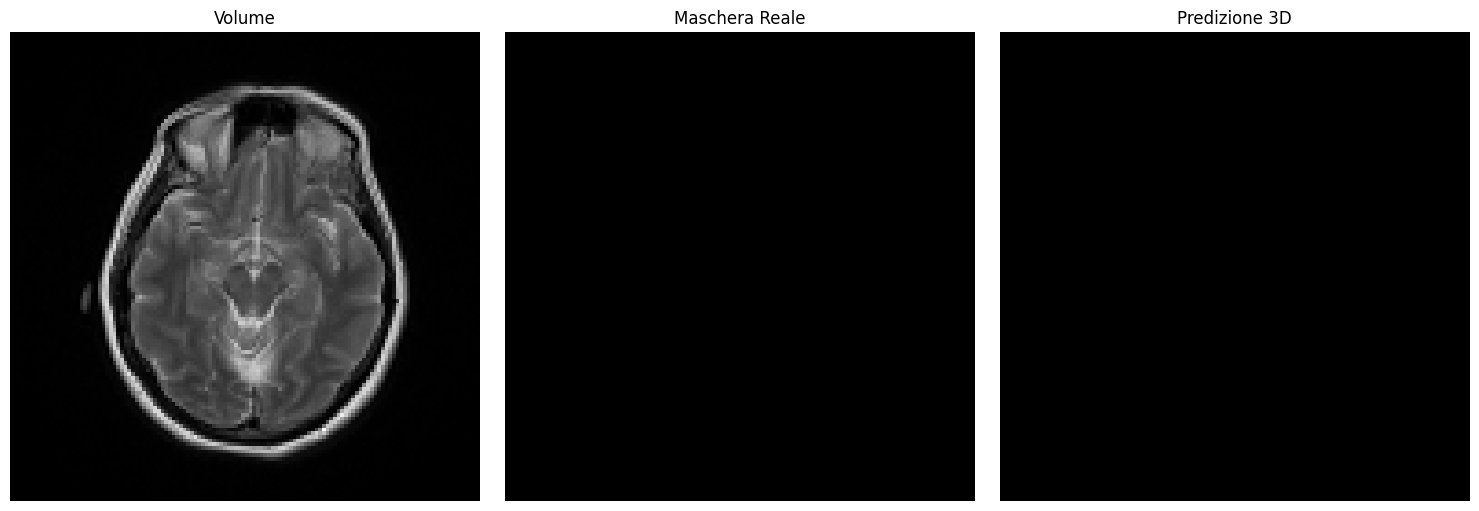

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

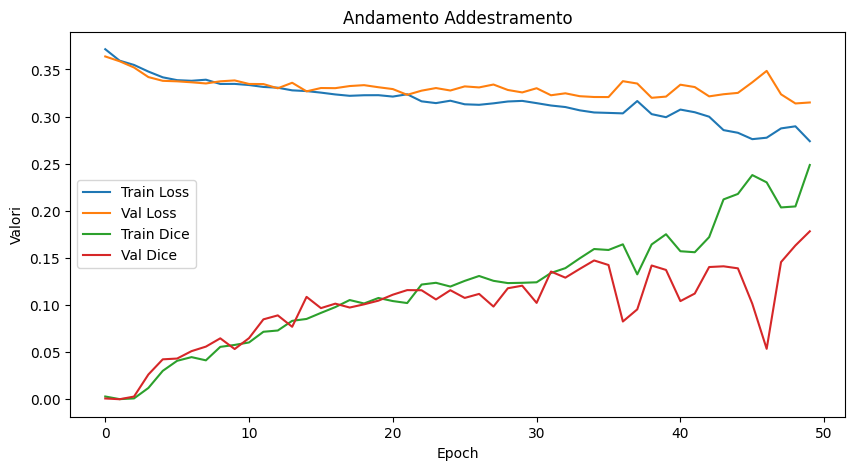

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

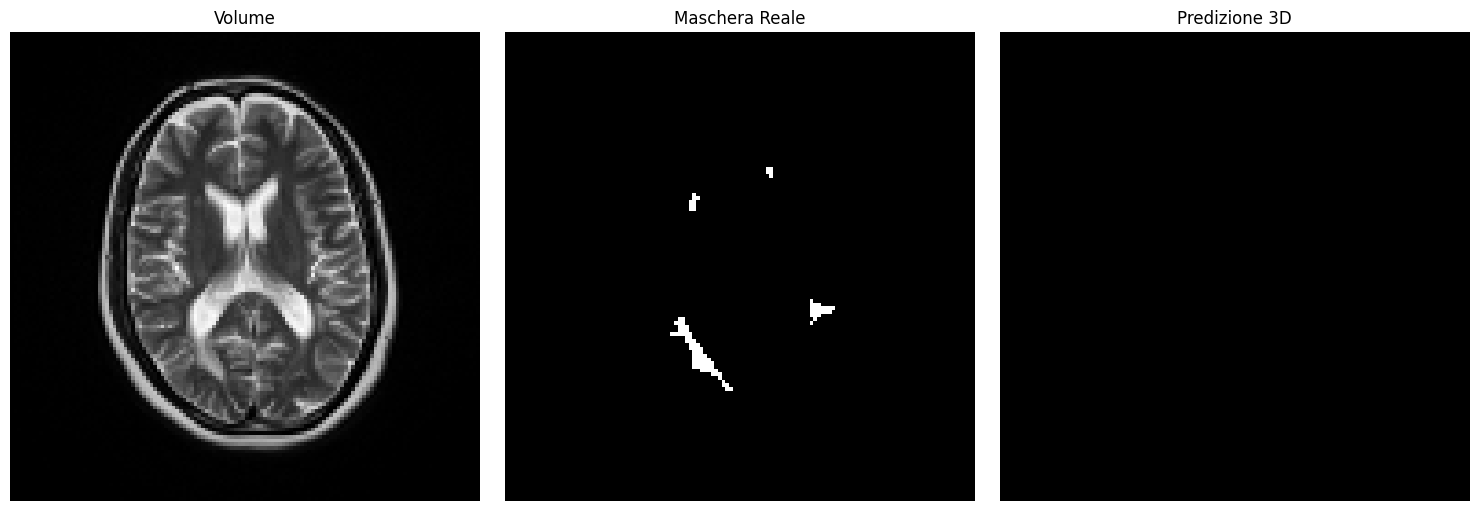

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

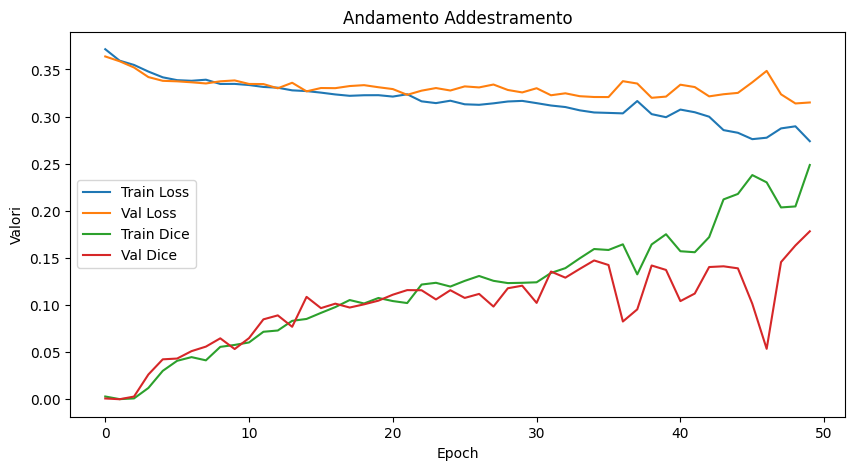

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

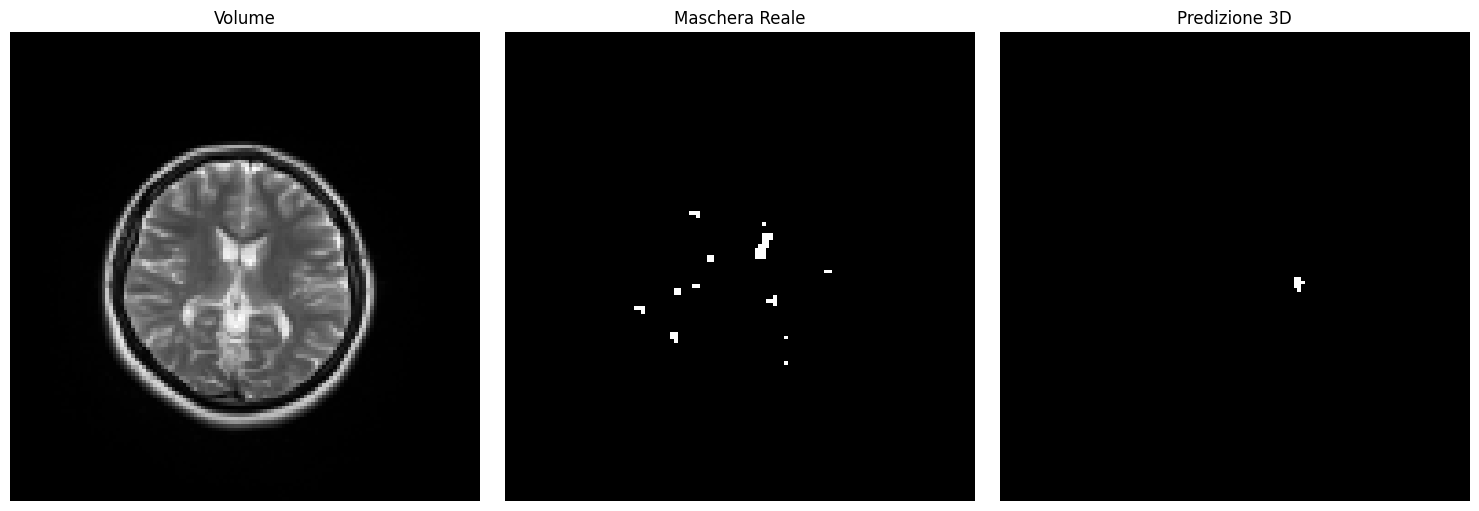

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

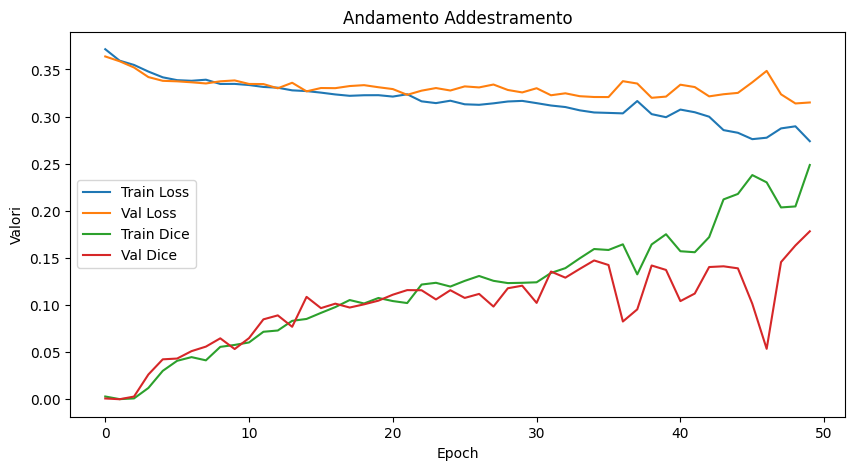

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

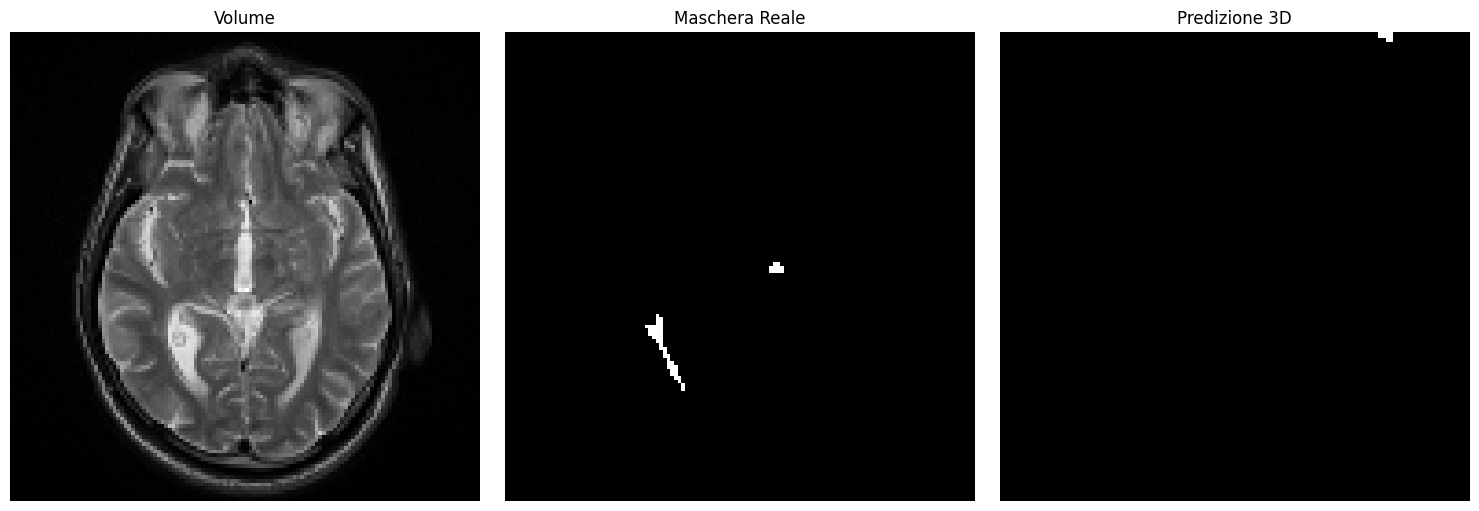

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

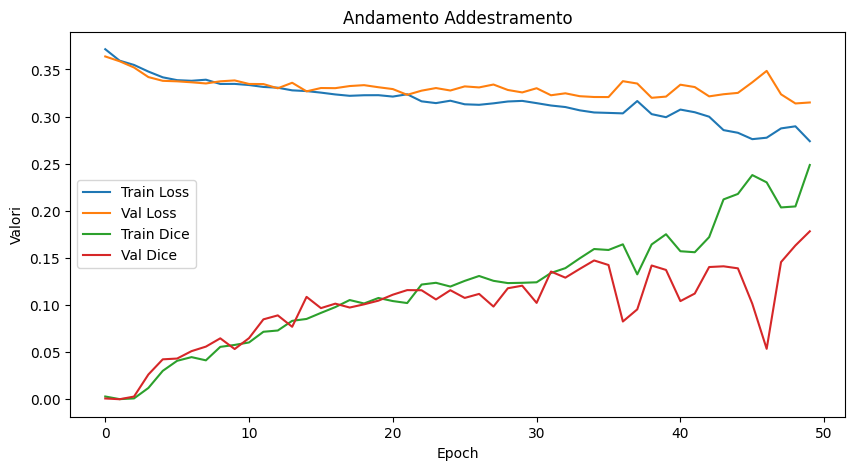

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

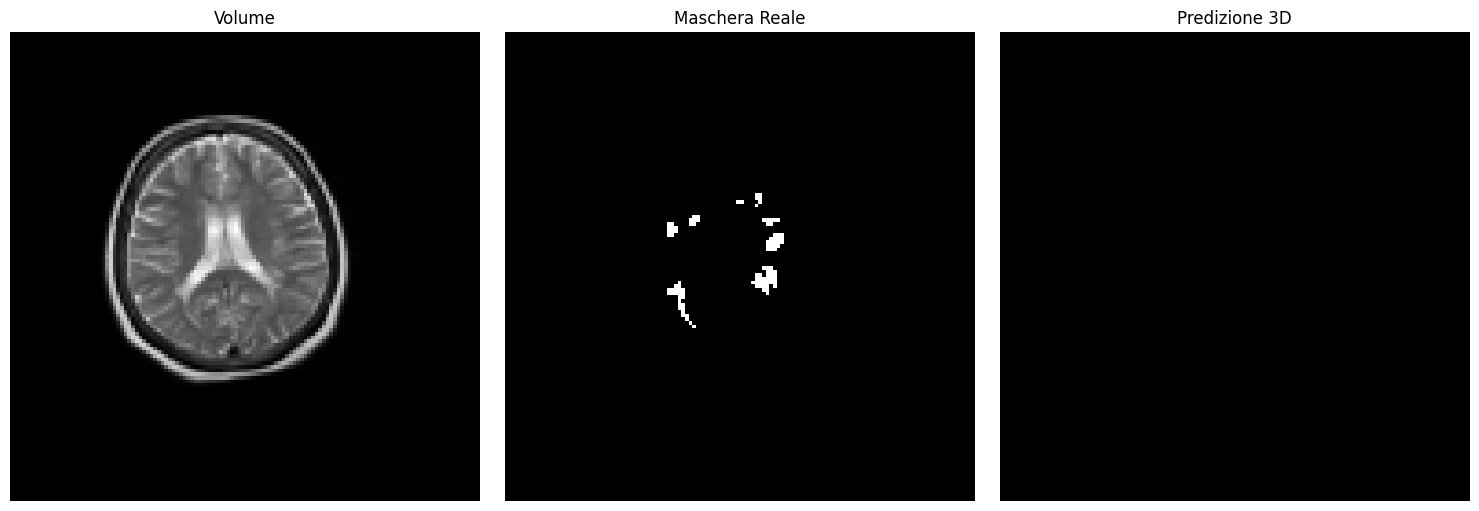

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

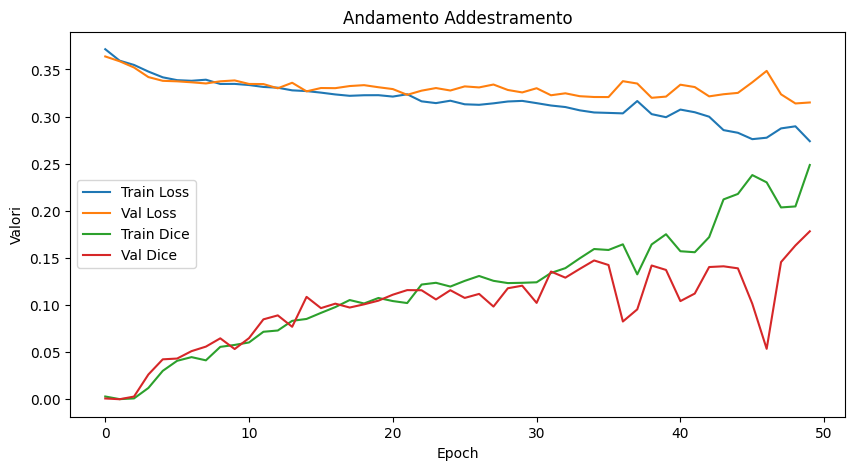

In [24]:
modality = "T2"

model_3d, history, data_split = train_3d_model(modality, target_shape=(128, 128, 64))

# Visualizzazione
test_volumes, test_masks, test_ids = data_split['test']
# Prova diversi pazienti finché non trovi una buona segmentazione
for i in [0, 1, 2, 3, 4]:
    visualize_3d_prediction(model_3d, test_volumes[i], test_masks[i], history, modality)